# Tutorial notebook 8: Multi-cell tissue prediction

In this tutorial, we will demonstrate how to finetune a Cell2Sentence model on multi-cell tasks. Single-cell analysis typically requires looking at many cells at once, so it can be useful to have a model that can reason about multiple cells at a time. LLMs provide flexibility in input prompt formatting, so we can easily modify the input prompt of Cell2Sentence to encode multiple cells in a single input.

In this tutorial, we will finetune a Cell2Sentence model on a multi-cell tissue prediction task. We will use the same dataset and model as in the previous tutorials, however each input sample will now contain multiple cells, and we will train on an example task of predicting the tissue type of a group of cells based on their gene expression.

At a high level, we will:
1. Construct an example multi-cell dataset by grouping cells together based on batch sample and tissue type.
2. Use a multi-cell prompt formatter to format our dataset for the multi-cell tissue prediction task.
3. Finetune a Cell2Sentence model on our multi-cell task.

We will use the same dataset and base C2S model as in the previous tutorials.

Import necessary libraries

In [1]:
# Python built-in libraries
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["WORLD_SIZE"] = "1"

import random
from datetime import datetime

# Third-party libraries
from datasets import Dataset, concatenate_datasets
import numpy as np
from tqdm import tqdm
from transformers import TrainingArguments

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.prompt_formatter import C2SMultiCellPromptFormatter
from cell2sentence.utils import train_test_split_arrow_ds

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [3]:
DATA_PATH = "/home/sr2464/scratch/C2S_Files/Cell2Sentence_Datasets/dominguez_conde_immune_tissue_two_donors_preprocessed_tutorial_0.h5ad"

In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs = adata.obs[["cell_type", "tissue", "batch_condition", "organism", "sex"]]

In [6]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,female


In [7]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


/home/ap2853/.conda/envs/scFB2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


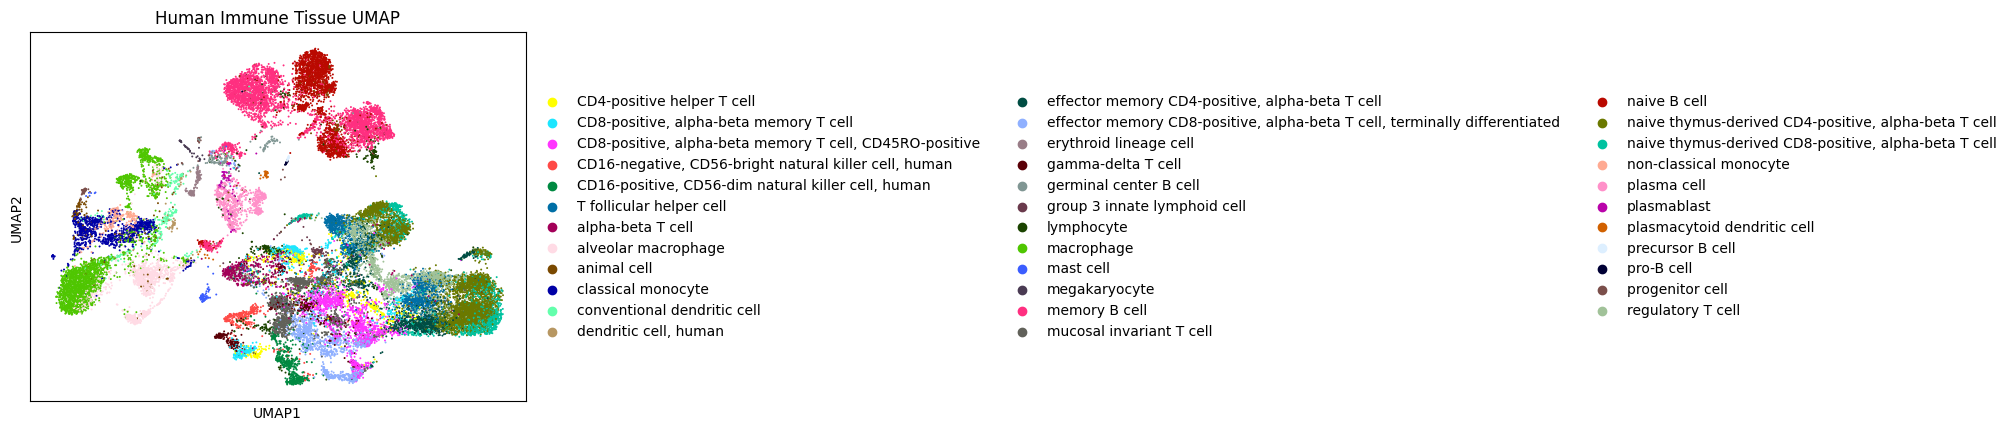

In [8]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [9]:
adata.X.max()

3.408124

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [10]:
adata_obs_cols_to_keep = adata.obs.columns.tolist()
adata_obs_cols_to_keep

['cell_type', 'tissue', 'batch_condition', 'organism', 'sex']

In [11]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 29773/29773 [00:10<00:00, 2973.20it/s]


In [12]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

In [13]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'Pan_T7935490_AAACCTGCAAATTGCC',
 'cell_sentence': 'RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5

# Grouping cells into multi-cell samples

Here we will construct an example multi-cell dataset by grouping cells together based on batch sample and tissue type. This will provide us example data for predicting the tissue type of a group of cells based on their gene expression.

Since we want to maintain a train/test split and not leak cells, only train set cells will be used to construct the training multi-cell dataset. The same will be true for the test set, only test set cells will be used to construct the test multi-cell dataset.

At a high level, the procedure will be:
1. Build a dictionary mapping a tuple of (batch sample, tissue type) to a list of cell indices which belong to that batch sample and tissue type.
2. For each sample in the original dataset, we sample 4 more cells from the dictionary which belong to the same batch sample and tissue type.
    - This keeps the overall size of our dataset the same, but results in each sample having 5 cells. Note that samples can have variable numbers of cells and metadata, but for this tutorial we will assume that each sample has the same number of cells, genes per cell sentence, and cell metadata.
3. Store the indices of multi-cell groupings in a new arrow dataset, so that the prompt formatter can build multi-cell sentences.
    - The multi-cell indices dataset will have the same number of samples as the original dataset, and each sample will consist of a list of 5 cell indices, indicating which cells should be grouped together to form a multi-cell sample.

In [14]:
# First, add a column for train/test split to the original dataset
split_ds_dict, data_split_indices_dict = train_test_split_arrow_ds(arrow_ds)
split_ds_dict

DatasetDict({
    train: Dataset({
        features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
        num_rows: 23847
    })
    validation: Dataset({
        features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
        num_rows: 2948
    })
    test: Dataset({
        features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
        num_rows: 2978
    })
})

Now, we'll define a function that takes as input a Huggingface cell sentence arrow dataset and returns a dictionary mapping a tuple of (batch sample, tissue type) to a list of cell indices which belong to that batch sample and tissue type.

In [15]:
def get_multi_cell_groupings(hf_ds):
    batch_tissue_to_cell_indices_dict = {}
    for sample_idx in range(hf_ds.num_rows):
        # Load sample, get batch sample and tissue type
        sample = hf_ds[sample_idx]
        batch_sample = sample["batch_condition"]
        tissue_type = sample["tissue"]

        # If new batch sample and tissue type combination is found, add to dictionary
        if (batch_sample, tissue_type) not in batch_tissue_to_cell_indices_dict:
            batch_tissue_to_cell_indices_dict[(batch_sample, tissue_type)] = []

        # Add sample index to dictionary
        batch_tissue_to_cell_indices_dict[(batch_sample, tissue_type)].append(sample_idx)
    return batch_tissue_to_cell_indices_dict

In [16]:
train_batch_tissue_to_cell_indices_dict = get_multi_cell_groupings(split_ds_dict["train"])
val_batch_tissue_to_cell_indices_dict = get_multi_cell_groupings(split_ds_dict["validation"])
test_batch_tissue_to_cell_indices_dict = get_multi_cell_groupings(split_ds_dict["test"])

In [17]:
print("(batch sample, tissue type): [list of cell indices with this combination]")
for key in train_batch_tissue_to_cell_indices_dict.keys():
    print(f"{key}:", train_batch_tissue_to_cell_indices_dict[key][:10])

(batch sample, tissue type): [list of cell indices with this combination]
('A29', 'ileum'): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
('A29', 'lung'): [281, 282, 283, 284, 285, 286, 287, 288, 289, 290]
('A29', 'thoracic lymph node'): [2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815]
('A29', 'mesenteric lymph node'): [6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488]
('A29', 'bone marrow'): [8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771]
('A29', 'skeletal muscle tissue'): [9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904]
('A29', 'liver'): [9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918]
('A29', 'spleen'): [10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451]
('A31', 'spleen'): [13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359, 13360]
('A31', 'ileum'): [15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054, 15055, 15056]
('A31', 'omentum'): [15073, 15074, 15075, 15076, 15077, 15078, 15079, 15080, 15081, 15082]
(

In [18]:
print("(batch sample, tissue type): [list of cell indices with this combination]")
for key in val_batch_tissue_to_cell_indices_dict.keys():
    print(f"{key}:", val_batch_tissue_to_cell_indices_dict[key][:10])

(batch sample, tissue type): [list of cell indices with this combination]
('A29', 'ileum'): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
('A29', 'lung'): [38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
('A29', 'thoracic lymph node'): [371, 372, 373, 374, 375, 376, 377, 378, 379, 380]
('A29', 'mesenteric lymph node'): [817, 818, 819, 820, 821, 822, 823, 824, 825, 826]
('A29', 'bone marrow'): [1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106]
('A29', 'skeletal muscle tissue'): [1232, 1233]
('A29', 'liver'): [1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243]
('A29', 'spleen'): [1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299]
('A31', 'spleen'): [1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675]
('A31', 'ileum'): [1905, 1906]
('A31', 'lung'): [1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916]
('A31', 'liver'): [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026]
('A31', 'thoracic lymph node'): [2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217

In [19]:
print("(batch sample, tissue type): [list of cell indices with this combination]")
for key in test_batch_tissue_to_cell_indices_dict.keys():
    print(f"{key}:", test_batch_tissue_to_cell_indices_dict[key][:10])

(batch sample, tissue type): [list of cell indices with this combination]
('A29', 'ileum'): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
('A29', 'lung'): [27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
('A29', 'thoracic lymph node'): [370, 371, 372, 373, 374, 375, 376, 377, 378, 379]
('A29', 'mesenteric lymph node'): [821, 822, 823, 824, 825, 826, 827, 828, 829, 830]
('A29', 'bone marrow'): [1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105]
('A29', 'liver'): [1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247]
('A29', 'spleen'): [1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318]
('A31', 'spleen'): [1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656]
('A31', 'ileum'): [1883, 1884, 1885, 1886, 1887]
('A31', 'omentum'): [1888, 1889, 1890, 1891]
('A31', 'lung'): [1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901]
('A31', 'liver'): [2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033]
('A31', 'thoracic lymph node'): [2211, 2212, 2213, 2214, 2215, 2216, 2217, 2

Now we define another function which will take as input a Huggingface cell sentence arrow dataset and a dictionary mapping a tuple of (batch sample, tissue type) to a list of cell indices, and return a new arrow dataset containing the multi-cell groupings.

Note that if we need metadata for the multi-cell samples, we should add a new column to the multi-cell arrow dataset in this step that contains the metadata for each multi-cell sample.

In [20]:
def get_multi_cell_arrow_ds(hf_ds, batch_tissue_to_cell_indices_dict):
    """
    Function to take in a Huggingface cell sentence arrow dataset and a dictionary 
    mapping a tuple of (batch sample, tissue type) to a list of cell indices, and 
    return a new arrow dataset containing the multi-cell groupings.

    Arguments:
        hf_ds: Huggingface arrow dataset containing cell sentences to group into multi-cells.
        batch_tissue_to_cell_indices_dict: Dictionary mapping a tuple of (batch sample, tissue type) to a list of cell indices.
    
    Returns:
        multi_cell_groupings_ds: Huggingface arrow dataset containing multi-cell groupings.
    """
    # Initialize list to store multi-cell groupings, each element is a list of 5 cell indices
    multi_cell_groupings_list = []
    batch_sample_labels = []
    tissue_type_labels = []
    organism_labels = []

    # Loop through each sample in original dataset - keeps number of overall samples (roughly) the same
    for sample_idx in tqdm(range(hf_ds.num_rows)):
        sample = hf_ds[sample_idx]
        batch_sample = sample["batch_condition"]
        tissue_type = sample["tissue"]

        # Retrieve list of cell indices for this batch sample and tissue type
        sample_key = (batch_sample, tissue_type)
        all_cell_indices = batch_tissue_to_cell_indices_dict[sample_key]
        if len(all_cell_indices) <= 5:
            # If there are less than 5 cells for this batch sample and tissue type, we will sample with replacement.
            #  Note that another option here would be to just skip this sample.
            sampled_cell_indices = random.choices(all_cell_indices, k=5)
        else:
            # If there are 5 or more cells for this batch sample and tissue type, we will sample without replacement
            sampled_cell_indices = random.sample(all_cell_indices, k=5)

        # Add list of sampled cell indices to multi-cell groupings list
        multi_cell_groupings_list.append(sampled_cell_indices)
        batch_sample_labels.append(sample["batch_condition"])
        tissue_type_labels.append(sample["tissue"])
        organism_labels.append(sample["organism"])  # all cells should be of the same organism

    multi_cell_groupings_ds = Dataset.from_dict({
        "multi_cell_groupings": multi_cell_groupings_list,
        "batch_label": batch_sample_labels,
        "tissue": tissue_type_labels,
        "organism": organism_labels,
    })
    return multi_cell_groupings_ds

In [21]:
train_multi_cell_arrow_ds = get_multi_cell_arrow_ds(split_ds_dict["train"], train_batch_tissue_to_cell_indices_dict)
val_multi_cell_arrow_ds = get_multi_cell_arrow_ds(split_ds_dict["validation"], val_batch_tissue_to_cell_indices_dict)
test_multi_cell_arrow_ds = get_multi_cell_arrow_ds(split_ds_dict["test"], test_batch_tissue_to_cell_indices_dict)

100%|██████████| 2978/2978 [00:00<00:00, 11434.93it/s]


Let's take a look and double check that all cells in one sample belong to the same batch sample and tissue type.

In [22]:
split_ds_dict["train"][0]

{'cell_name': 'Pan_T7935490_AAACGGGCATCTGGTA',
 'cell_sentence': 'TMSB4X MT-CO1 B2M MT-CO2 MALAT1 HSPA1A ACTB HSP90AA1 RPLP1 MT-CO3 MT-CYB RPS27 JUNB MT-ND3 EEF1A1 HSPA1B HLA-B RPL41 RPS18 CD69 DNAJB1 JUN CCL5 RPL10 RPL28 FOS MT-ND4L MT-ATP8 RPS19 IL32 TPT1 RPL39 IFNG RPL13 FTH1 PPP1R15A RPS15A RPS14 PFN1 ZFP36 HLA-C CD52 EIF1 SH3BGRL3 PTMA MT-ATP6 RPS12 FTL ACTG1 NR4A2 RPS3 RPS15 GAPDH RPLP2 RPL11 HLA-A RPS4X TNFAIP3 RPL34 RPL18 RPL32 RPL37 RPL30 MT-ND1 RPL8 RPL19 RPS23 RPL18A MT-ND2 GZMA UBC NKG7 RPL21 RPS21 RPS27A RPS28 RPL35A GADD45B H3-3B RPS24 RPL3 RPL29 RPS6 VIM SELENOK RPLP0 S100A4 RPL26 RPS13 CD8A MTRNR2L12 RPS25 CD3E CD3D RPS7 FAU CFL1 RPL12 DUSP1 RPS8 HSPA8 RPS3A RPL9 SRSF7 RPL14 HLA-E RPL36 TRBV9 MT-ND5 RPS2 RPL27 CRIP1 ARHGDIB TMSB10 RAC2 MIF MT-ND4 H4C3 DUSP5 IER2 ZFP36L1 RPS9 MYL12A MYL6 NFKBIA RPL7A TAGLN2 RPS16 UBA52 PPIB RPS5 SERF2 RPL23A SRGN RPSA RPL24 RPL22 ATF3 PCBP2 RPL15 S100A6 PNRC1 DDIT3 RPL4 CALM1 NR4A1 TRAV4 EEF2 HOPX TPM3 ATP5F1E CORO1A CALR COTL1 UBB GZMM 

In [23]:
train_multi_cell_arrow_ds

Dataset({
    features: ['multi_cell_groupings', 'batch_label', 'tissue', 'organism'],
    num_rows: 23847
})

In [24]:
train_multi_cell_arrow_ds[0]

{'multi_cell_groupings': [225, 59, 3, 46, 17],
 'batch_label': 'A29',
 'tissue': 'ileum',
 'organism': 'Homo sapiens'}

In [25]:
for cell_idx in train_multi_cell_arrow_ds[0]["multi_cell_groupings"]:
    print(f"Cell {cell_idx}:", split_ds_dict["train"][cell_idx]["batch_condition"], split_ds_dict["train"][cell_idx]["tissue"])

Cell 225: A29 ileum
Cell 59: A29 ileum
Cell 3: A29 ileum
Cell 46: A29 ileum
Cell 17: A29 ileum


Now we have the arrow datasets which we need for training: the original cell sentence arrow dataset, and the multi-cell groupings arrow dataset.

# Multi-cell Prompt Formatting

Here, we will use the C2SMultiCellPromptFormatter class to format a few example multi-cell samples to see what the formatted dataset looks like.

In [26]:
task_name = "tissue_prediction"
prompt_formatter = C2SMultiCellPromptFormatter(
    task=task_name,
    top_k_genes=100
)
prompt_formatter

Let's format a few dataset samples with our custom prompt template to see what the formatted dataset looks like.

In [27]:
small_example_ds = train_multi_cell_arrow_ds.select(range(10))
small_example_ds

Dataset({
    features: ['multi_cell_groupings', 'batch_label', 'tissue', 'organism'],
    num_rows: 10
})

In [28]:
small_example_ds[0]

{'multi_cell_groupings': [225, 59, 3, 46, 17],
 'batch_label': 'A29',
 'tissue': 'ileum',
 'organism': 'Homo sapiens'}

In [29]:
formatted_small_example_ds = prompt_formatter.format_hf_ds(
    hf_ds=split_ds_dict["train"],
    multi_cell_indices_ds=small_example_ds
)
formatted_small_example_ds

Dataset({
    features: ['sample_type', 'model_input', 'response'],
    num_rows: 10
})

In [30]:
formatted_small_example_ds[0]

{'sample_type': 'tissue_prediction',
 'model_input': 'Consider these 100 highly expressed genes, ordered by descending expression, from 5 Homo sapiens cells. Based on the information, your task is to predict the associated tissue type of these cells.\nCell sentences:\nCell 1:\nMALAT1 B2M MT-CO1 TMSB4X HSP90AA1 RPLP1 HSPA1A ACTB HLA-B EEF1A1 MT-CO2 MT-CO3 HSPA8 KLF6 CD69 RPS27 RPS19 CCL5 RPL13 RPS12 NR4A2 DUSP1 MT-ND3 TRAV38-2DV8 JUN RPL34 RPL41 UBC ACTG1 RPS18 RPL28 HLA-C TPT1 RPL32 DNAJB1 RPS15A RPS4X RPL30 ZFP36 RPL35A RPL19 MT-ATP8 RPS21 H3-3B RPS3 RPS29 IFITM1 PFN1 RPS2 MT-CYB RPS28 PPP1R15A JUNB HLA-A IL32 RPS23 RPL7A RPS14 TMSB10 RPS25 RPS15 RPS27A MT-ND1 SRSF7 RPL10 HSP90AB1 FTH1 RPL3 UBB IER2 EIF1 RPS13 RPL11 MT-ATP6 CALM1 RPS8 RPL29 RPS7 RPL39 HLA-E RPLP2 ZFP36L1 MT-ND4L RPL8 FAU NR4A1 TRBV7-6 RPLP0 RPL12 BTG2 CRTAM RPS16 MT-ND4 RPL27A GAPDH RPS6 HSPA1B STK17B RPL37 RPL18A.\nCell 2:\nFTH1 DNAJB1 EEF1A1 HSPA1A RPLP1 MALAT1 B2M HSP90AA1 KLF6 RPL10 RPS27 ACTB RPL41 RPL39 RPS12 BT

In [31]:
print("#----Model input:----#")
print(formatted_small_example_ds[0]["model_input"], "\n")
print("#----Response:----#")
print(formatted_small_example_ds[0]["response"])

#----Model input:----#
Consider these 100 highly expressed genes, ordered by descending expression, from 5 Homo sapiens cells. Based on the information, your task is to predict the associated tissue type of these cells.
Cell sentences:
Cell 1:
MALAT1 B2M MT-CO1 TMSB4X HSP90AA1 RPLP1 HSPA1A ACTB HLA-B EEF1A1 MT-CO2 MT-CO3 HSPA8 KLF6 CD69 RPS27 RPS19 CCL5 RPL13 RPS12 NR4A2 DUSP1 MT-ND3 TRAV38-2DV8 JUN RPL34 RPL41 UBC ACTG1 RPS18 RPL28 HLA-C TPT1 RPL32 DNAJB1 RPS15A RPS4X RPL30 ZFP36 RPL35A RPL19 MT-ATP8 RPS21 H3-3B RPS3 RPS29 IFITM1 PFN1 RPS2 MT-CYB RPS28 PPP1R15A JUNB HLA-A IL32 RPS23 RPL7A RPS14 TMSB10 RPS25 RPS15 RPS27A MT-ND1 SRSF7 RPL10 HSP90AB1 FTH1 RPL3 UBB IER2 EIF1 RPS13 RPL11 MT-ATP6 CALM1 RPS8 RPL29 RPS7 RPL39 HLA-E RPLP2 ZFP36L1 MT-ND4L RPL8 FAU NR4A1 TRBV7-6 RPLP0 RPL12 BTG2 CRTAM RPS16 MT-ND4 RPL27A GAPDH RPS6 HSPA1B STK17B RPL37 RPL18A.
Cell 2:
FTH1 DNAJB1 EEF1A1 HSPA1A RPLP1 MALAT1 B2M HSP90AA1 KLF6 RPL10 RPS27 ACTB RPL41 RPL39 RPS12 BTG1 RPL13 PTMA MT-CO3 TMSB4X MT-CO1 R

We can see that the model input is formatted with multiple cell sentences, and the response is the tissue type annotation for the multi-cell sample. This is an example of how we can modify the input prompt of Cell2Sentence to encode multiple cells depending on our downstream task.

Many prompt variations are possible, and variable number of cells or metadata can be given in input prompts. The only limitation is formatting input prompts accurately depending on the task.

We'll now format the full training, validation, and test datasets.

In [32]:
train_formatted_ds = prompt_formatter.format_hf_ds(
    hf_ds=split_ds_dict["train"],
    multi_cell_indices_ds=train_multi_cell_arrow_ds
)
val_formatted_ds = prompt_formatter.format_hf_ds(
    hf_ds=split_ds_dict["validation"],
    multi_cell_indices_ds=val_multi_cell_arrow_ds
)
test_formatted_ds = prompt_formatter.format_hf_ds(
    hf_ds=split_ds_dict["test"],
    multi_cell_indices_ds=test_multi_cell_arrow_ds
)

We'll concatenate the formatted training, validation, and test datasets into a single dataset, and make a data split indices dictionary to keep track of which samples belong to which dataset split. The finetune() function will use this data split indices dictionary to split the dataset into train, validation, and test sets.

In [33]:
full_formatted_ds = concatenate_datasets([train_formatted_ds, val_formatted_ds, test_formatted_ds])
full_formatted_ds

Dataset({
    features: ['sample_type', 'model_input', 'response'],
    num_rows: 29773
})

In [34]:
train_indices = list(range(len(train_formatted_ds)))
val_indices = list(range(len(train_formatted_ds), len(train_formatted_ds) + len(val_formatted_ds)))
test_indices = list(range(len(train_formatted_ds) + len(val_formatted_ds), len(train_formatted_ds) + len(val_formatted_ds) + len(test_formatted_ds)))
print(len(train_indices), len(val_indices), len(test_indices))
print(len(train_indices) + len(val_indices) + len(test_indices))  # Check that total number of samples is correct

23847 2948 2978
29773


In [35]:
print(train_indices[:10])
print(val_indices[:10])
print(test_indices[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[23847, 23848, 23849, 23850, 23851, 23852, 23853, 23854, 23855, 23856]
[26795, 26796, 26797, 26798, 26799, 26800, 26801, 26802, 26803, 26804]


In [36]:
data_split_indices_dict = {
    "train": train_indices,
    "val": val_indices,
    "test": test_indices,
}

# Create CSData object

As one last data step, we need to create a CSData object which will wrap around our arrow dataset.

In [37]:
c2s_save_dir = "/home/ap2853/scratch/c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "dominguez_immune_tissue_tutorial8"  # This will be the name of our C2S dataset on disk

In [38]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/29773 [00:00<?, ? examples/s]

In [39]:
print(csdata)

CSData Object; Path=/home/ap2853/scratch/c2s_api_testing/dominguez_immune_tissue_tutorial8, Format=arrow


# Load Cell2Sentence Model

Now, we will load a C2S model which will finetune on a new dataset, as in tutorial 3. This model can be a LLM pretrained on natural language, or it can be a trained C2S model which will undergo further finetuning on a new dataset of interest. Typically, starting from a pretrained C2S model benefits performance, since C2S models were initialized from natural language-pretrained LLMs and trained on many single-cell datasets on different tasks.

For this tutorial, we will start finetuning from the C2S-Pythia-410M cell type prediction model, which was trained to do cell type prediction on many datasets from CellxGene and Human Cell Atlas. More details about the C2S-Pythia-410M cell type prediction model can be found in the Model Zoo section of the ReadME in the GitHub repo, or in the Huggingface model card.

We can define our CSModel object with our pretrained cell type prediction model as follows:

In [40]:
# Define CSModel object
model_name_or_path = "vandijklab/C2S-Pythia-410m-diverse-single-and-multi-cell-tasks"
save_dir = "/home/ap2853/scratch/c2s_api_testing"
save_name = "diverse_tasks_pythia_410M_tutorial8"
csmodel = cs.CSModel(
    model_name_or_path=model_name_or_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


In [41]:
print(csmodel)

CSModel Object; Path=/home/ap2853/scratch/c2s_api_testing/diverse_tasks_pythia_410M_tutorial8


# Finetune on new dataset

Now, we will finetune our C2S model on our custom task. The finetune() function will format the full dataset for us using our CustomPromptFormatter instance, so we just need to pass in our custom prompt formatter to the finetune() function.

For training, we will need to define training arguments for finetuning our C2S model on our new dataset. Huggingface's Trainer class is used to do training, so we can utilize different training techniques (e.g. mixed precision training, gradient accumulation, gradient checkpointing, etc.) by specifying the corresponding option in the TrainingArguments object. This gives us a vast array of possible options for training, and will allow us to specify important parameters such as batch size, learning rate, and learning rate schedulers. See the full documentation for training arguments at:
- https://huggingface.co/docs/transformers/en/main_classes/trainer

In [42]:
task_name

'tissue_prediction'

In [43]:
datetimestamp = datetime.now().strftime('%Y-%m-%d-%H_%M_%S')
output_dir = os.path.join(csmodel.save_dir, datetimestamp + f"_finetune_{task_name}")
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
print(output_dir)

/home/ap2853/scratch/c2s_api_testing/2024-12-08-12_06_53_finetune_tissue_prediction


Here, we define our training arguments. For this tutorial, we will use a batch size of 8 with 4 gradient accumulation steps, yielding an effective batch size of 32. We will use a learning rate of 1e-5 with a cosine annealing scheduler, and we will train for 5 epochs total. Some other important parameters specified here are:
- bf16: Uses mixed-precision training with bfloat16 dtype
- logging_steps: controls how often we log training loss
- eval_steps: controls how often we run the eval loop
- warmup_ratio: percentage of training in which learning rate warms up to the base learning rate specified

Full explanations of all possible training arguments can be found in the Huggingface Trainer documentation: 

https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/trainer#transformers.TrainingArguments

In [44]:
train_args = TrainingArguments(
    bf16=True,
    fp16=False,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    logging_steps=50,
    logging_strategy="steps",
    lr_scheduler_type="cosine",
    num_train_epochs=5, 
    eval_steps=50,
    evaluation_strategy="steps",
    save_steps=100,
    save_strategy="steps",
    save_total_limit=3,
    warmup_ratio=0.05,
    output_dir=output_dir,
    max_steps=1000  # Set a maximum number of steps - shortened to 1k steps for tutorial purposes
)

/home/ap2853/.conda/envs/scFB2/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead


In [45]:
csmodel.fine_tune(
    csdata=csdata,
    task=task_name,
    train_args=train_args,
    loss_on_response_only=False,
    top_k_genes=100,
    max_eval_samples=500,
    prompt_formatter=prompt_formatter,
    formatted_hf_ds=full_formatted_ds,  # Pass in formatted dataset, so that formatting is not done again
    data_split_indices_dict=data_split_indices_dict,  # Pass in data split indices dictionary
    num_proc=1  # Use only 1 process for tokenization
)


Reloading model from path on disk: /home/ap2853/scratch/c2s_api_testing/diverse_tasks_pythia_410M_tutorial8


Map:   0%|          | 0/29773 [00:00<?, ? examples/s]

/gpfs/radev/home/ap2853/cell2sentence/src/cell2sentence/csmodel.py:210: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting training. Output directory: /home/ap2853/scratch/c2s_api_testing/2024-12-08-12_06_53_finetune_tissue_prediction
Selecting 500 samples of eval dataset to shorten validation loop.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
max_steps is given, it will 

Step,Training Loss,Validation Loss
50,4.821400,1.194275
100,4.758800,1.190113
150,4.715400,1.185355
200,4.685200,1.181592
250,4.711300,1.176304
300,4.657900,1.171957
350,4.644000,1.171365
400,4.644700,1.167198
450,4.687100,1.169040
500,4.654900,1.161656


Finetuning completed. Updated model saved to disk at: /home/ap2853/scratch/c2s_api_testing/2024-12-08-12_06_53_finetune_tissue_prediction
